# CASE 1. Predicting Heart Condition


- Eliecer Diaz Diaz,
- Muskan Kaushik 
- Zakaria Hasan

In [149]:
#INDEX

#I.    Background
#II.   Methods
#III.  Model Exploration and Preprocessing
#IV.   Model Fitting
#V.    Model Selection
#VI.   RESULTS and Discussion
#VII.  Coclusion
#VIII. References

# I. BACKGROUND

Deep Learning seems to have a promising amd dramatic impact on the health field; as a result, familiarizing ourself with the data processing techniques and with the most widely used algorithms for classification is valuable to contribute in the field of health sciences.

Cleveland data set contains patient data concerning heart disease diagnosis.
The dataset contains 14 attributes, eight of them were categorical, and six of them continuous and numeric.
The goal of this study is test few dense neural networks to be able to predict if a patient presents heart disease or not.

Objectives:
- This project aimed to predict heart disease condition using neural networks as a binary classifier.
- Practice preprocessing and neural network techniques, as well as the use of metrics to analyse them.

# II. METHODS

We proceed to examine the dataset and conduct a preprocessing following these points:
Correct variable format:  if the documentation says it is categorical (level of pain 1, 2, 3, 4), it should not appear as a float.
We removed rows containing NaN.
We standardized continuous features (numeric/float).
We encoded (one-hot encoding or dummy) categorical features.
We check for high correlation among features (collinearity) and outliers.

Second, we split the data into features and labels, and then we split them into training, validation and test set.
Third: we proceed to train Neural Networks; our strategy started with a small and another large neural network. Each one was tunned using dropout, changing the activation, the number of neurones. Every time we took a close look at the performance of validation and training set, plotting them in terms of accuracy and loss. When over-fitting was detected, a new tunning method was applied. For space reason, we included only three Neural Networks out of a total of 50 attemps to find the right Neural Network, which does not overfit.
Fourth: We compare the performance of the three best models using ROC curves, and finally, the best one (the most significant area under the curve AUC).
Fifth, we got the final scores checking the confusion matrix on the F1-score.

In [1]:
%pylab inline
import random
random.seed(30)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Loading data, add the column names:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
col_name = ['age',
            'sex',
             'cp',
             'chol',
             'trestbps',
             'fbs',
             'restecg',
             'thalach',
             'exang',
             'olddek',
             'slope',
             'ca',
             'thal',
             'num'
    
]
df = pd.read_csv(filename,
                index_col = None,
                header = None,
                names = col_name,
                na_values = '?')

# III. MODEL EXPLORATION AND PRE-PROCESSING

In [3]:
# checking the shape of the data:
df.shape # 303 by 14 columns

(303, 14)

In [4]:
# Which are the rows with missing data?
null_data = df[df.isnull().any(axis=1)]
null_data

,age,sex,cp,chol,trestbps,fbs,restecg,thalach,exang,olddek,slope,ca,thal,num
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,NaN,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,NaN,3.0,0


In [5]:
# Removing the NaN rows, they were only 6
df = df.dropna()
#df.head()
df.shape

(297, 14)

In [6]:
# What are the types?
df.dtypes

age         float64
sex         float64
cp          float64
chol        float64
trestbps    float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
olddek      float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object

Obviously there is something error since there are some categorical variables,
then not all the variables can be float, see documentation:

In [7]:
#############################
# DETAILS about the dataset:#
#############################

#age: age in years 
#sex: sex (1 = male; 0 = female)                                 <-----should be category
#cp: chest pain type                                             <-----should be category
#        -- Value 1: typical angina
#        -- Value 2: atypical angina
#        -- Value 3: non-anginal pain
#        -- Value 4: asymptomatic
#restbps: resting blood pressure (in mm Hg on admission to the 
#        hospital)            
#chol: serum cholestoral in mg/dl
#fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false) <-----should be category   
#restecg: resting electrocardiographic results                 <-----should be category
#        -- Value 0: normal
#        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
#                    elevation or depression of > 0.05 mV)
#        -- Value 2: showing probable or definite left ventricular hypertrophy
#                    by Estes' criteria
#thalach: maximum heart rate achieved
#exang: exercise induced angina (1 = yes; 0 = no)             <-----should be category
#olddek: ?? (continuous)
#slope: the slope of the peak exercise ST segment             <-----should be category
#        -- Value 1: upsloping
#        -- Value 2: flat
#        -- Value 3: downsloping
#ca: number of major vessels (0-3) colored by flourosopy       <-----should be INTEGER
#thal: 3 = normal; 6 = fixed defect; 7 = reversable defect     <-----should be category
#num: diagnosis of heart disease (angiographic disease status) <-----should be category
#        -- Value 0: < 50% diameter narrowing
#        -- Value 1: > 50% diameter narrowing
#        (in any major vessel: attributes 59 through 68 are vessels)

Here we proceed to transform the variables:

In [8]:
df["sex"] = df["sex"].astype('category')
df["cp"] = df["sex"].astype('category')
df["fbs"] = df["fbs"].astype('category')
df["restecg"] = df["restecg"].astype('category')
df["slope"] = df["slope"].astype('category')
df["ca"] = df["ca"].astype('category')
df["thal"] = df["thal"].astype('category')
df["exang"] = df["exang"].astype('category')
df["num"] = df["num"].astype('category')

In [9]:
df.dtypes

age          float64
sex         category
cp          category
chol         float64
trestbps     float64
fbs         category
restecg     category
thalach      float64
exang       category
olddek       float64
slope       category
ca          category
thal        category
num         category
dtype: object

Now thre features are in the right type

We proceed to shuffle the row to have an effective data splitting (to avoid any order or grouping in the data set):

In [10]:
#SHUFFLING
df = df.sample(frac=1)

# FIRST SPLIT: Feature matrix(X) and Labers (Y)

In [11]:
X = df.iloc[:, 0:13] # DATA
Y = 1*(df.iloc[:, 13].astype('float64') > 0) 


In [12]:
#Get the categorial variables in one dataframe separated from the continuos data
# only because it is easier to do encoding. (PRACTICAL REASON)

Xcate = X[["sex", "fbs", "restecg", "slope", "ca", "thal"]]
Xnume = X.select_dtypes(include=['float64'])

In [13]:
Y.dtype # YES, integer

dtype('int64')

In [14]:
# Put in memory the column names in case they get lost with a numpy transformation (PRACTICAL REASON):
column_Xcate = Xcate.columns.get_values()
column_Xnume = Xnume.columns.get_values()

#STANDARZDIZATION for numeric variables/features:

In [15]:
from sklearn.preprocessing import StandardScaler
Xnume_STD = StandardScaler().fit_transform(Xnume)
Xnume_STD = pd.DataFrame(Xnume_STD, columns = column_Xnume)

In [17]:
#ending standardization of numerical variables

Appending, the numeric variables to the categorixal variables:

In [18]:
X_STD = pd.concat([Xnume_STD, Xcate], axis=1)
X_STD.head(3)

,age,chol,trestbps,thalach,olddek,sex,fbs,restecg,slope,ca,thal
0,-1.277559,-0.546646,-0.661726,0.672433,-0.734914,1.0,1.0,2.0,3.0,0.0,6.0
1,0.382746,1.032342,0.686763,0.541445,-0.047722,1.0,0.0,2.0,2.0,3.0,3.0
2,-1.941680,-0.659431,-0.623198,0.890746,-0.906712,1.0,0.0,2.0,2.0,2.0,7.0


START ONE-HOT ENCONDING OF CATEGORICAL FEATURES:

In [19]:
X_enc_STD = pd.get_dummies(X_STD) # pandas function to One-hot encoding
X_enc_STD.dropna(inplace= True)
X_enc_STD.tail(10)

,age,chol,trestbps,thalach,olddek,sex_0.0,sex_1.0,fbs_0.0,fbs_1.0,restecg_0.0,...,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
287,-0.170689,-0.095506,-0.969952,0.104820,0.124076,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288,-0.613437,0.130063,0.455593,0.541445,-0.906712,0,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
289,1.710989,1.596266,0.417065,-1.641684,1.584359,0,1,1,0,1,...,0,0,1,1,0,0,0,1,0,0
290,1.046868,2.724115,1.495856,0.192145,-0.906712,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,1
291,0.382746,0.017278,-0.449820,1.021734,1.842056,1,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0
292,-0.060002,3.400824,0.686763,1.982310,-0.906712,0,1,1,0,1,...,0,0,1,1,0,0,0,0,1,0
293,0.161372,-0.659431,-0.218651,1.240047,-0.219520,0,1,1,0,0,...,1,0,0,0,0,1,0,0,0,1
294,1.378929,-0.941393,6.099981,0.454120,0.467672,1,0,1,0,1,...,0,1,0,1,0,0,0,1,0,0
295,0.936181,-1.336140,0.417065,0.847083,0.639470,0,1,1,0,1,...,1,0,0,1,0,0,0,1,0,0
296,-1.166872,-0.772215,-0.103066,-0.026168,-0.649015,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0


Ready to feed the NN!

In order to have a feeling on how the variables behave in predicting heart condition we did this plot:

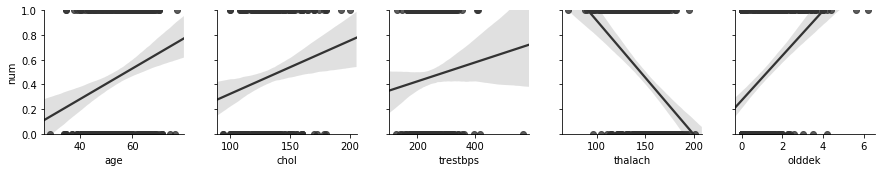

In [20]:
data = pd.concat([X, Y], axis=1)
g = sns.PairGrid(data, x_vars = ['age', 'chol', 'trestbps', 'thalach', 'olddek'], y_vars= ["num"], height=2.5)
g.map(sns.regplot, color="0.2")
g.set(ylim=(0, 1));

FIGURE 1. The figure shows that the following factors contribute positively to develop heart condition: age, cholesterol (Chol), resting blood pressure (trestbps), depression induced by exercise relative to rest (olddek), while maximum heart rate achieved (thalach), it is a sign of the healthiness.

EXAMINIG COLLINEARITY

In [21]:
# examining COLLINEARITY:

#lets have a look the relationship among variables:
corr_X = Xnume_STD.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_X, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True # Triangule or square

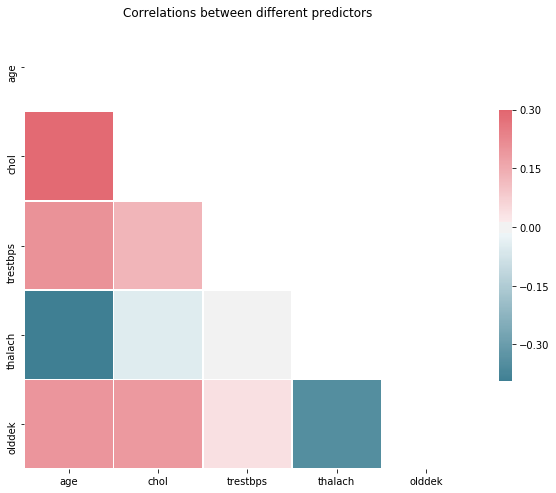

In [22]:
f, ax = plt.subplots(figsize=(10, 10))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_X, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlations between different predictors')
plt.show()


FIGURE 2. This chart matrix of correlations indicates no problem of collinearity; each correlation between features was lower r = 0.75 (Zuur et al. 2010)

/home/elvi/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


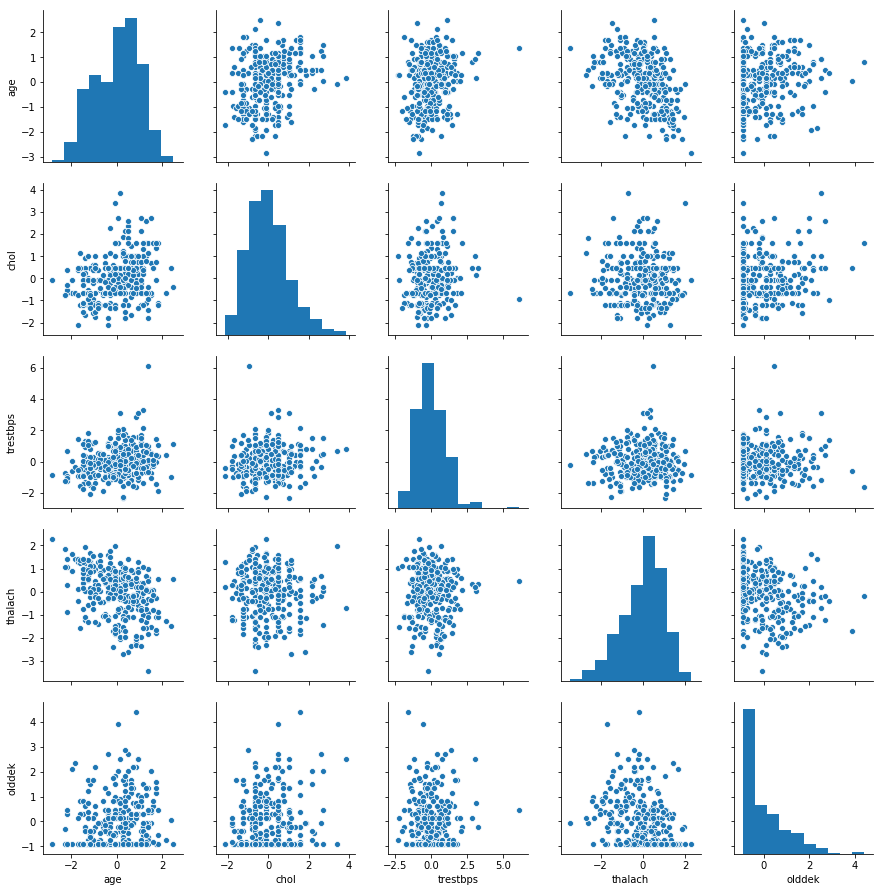

In [56]:
import seaborn as sns
sns.pairplot(Xnume_STD, size = 2.5) #DOUBLE CHECKING VISUALLY!

FIGURE 3. Examine if the data has been centered to zero and detect the presence of outliers. 

We tried to eliminate some points, but in the end they continue appearing, in spite of their elimination. We decided to leave the data as it was originally, because eliminating few outliers reduced the sample size dramtically.

**SECOND SPLIT: Training, Test and Validation**

In [57]:
#SPLITTING DATA into training and testing:
X_train, X_test, y_train, y_test = train_test_split(X_enc_STD, Y, test_size = 0.20)

In [58]:
X_train.shape

(237, 22)

In [59]:
partial_train_data = X_train[:200] #taking 300 rows
partial_train_targets = y_train[:200]
#Validation set
val_data = X_train[200:]
val_targets = y_train[200:]

TRANSFORMATION USING NUMPY

In [60]:
partial_train_data.values
partial_train_targets.values
val_data.values
val_targets.values 

array([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0])

Checking for the balance of the data

In [61]:
#checking for the balance of the data

Balance = partial_train_targets.value_counts()
category = ['1', '0']
partial_train_targets.value_counts()

0    111
1     89
Name: num, dtype: int64

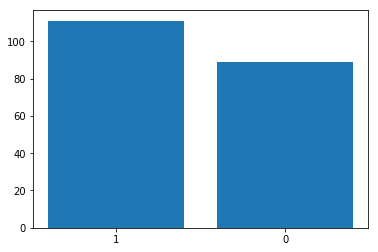

In [62]:
plt.bar(category, Balance)
#plt.xticks(category, objects)
plt.show()

FIGURE 4. Chart number of samples per patient condition: 1. sick, and 2. healthy. Chart shows
    an inbalance in the dataset.

In [92]:
print((111)/(111+89)) # THRESHOLD
default_accuracy = (111)/(111+89)

0.555


Since the training set is imbalanced we can expect a baseline/threshold 
for the classifier of 55%, so there is a higher chance (>7%) to detect sick patients (1), than
none sick patients by default. 
The model used should improve this chance.

# IV. MODEL FITTING

# MODEL 1: several layers

In [82]:
# The actual NN (very dense layer)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5, input_shape=(partial_train_data.shape[1],), activation='sigmoid'),
  tf.keras.layers.Dense(20, activation='sigmoid'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(16, activation='sigmoid'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='sigmoid'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


In [83]:
#model.summary()

In [84]:
#opt = tf.keras.optimizers.RMSprop(lr = 0.005, momentum = 0.3) # Here we reduce the Learning rate from 0.01 (default) tp 0.0025

In [85]:
model.compile(optimizer= 'adam',
              loss= 'binary_crossentropy',#'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [86]:
history = model.fit(partial_train_data, partial_train_targets,
                    epochs= 500, batch_size=10, verbose=0,
                    validation_data = (val_data, val_targets))

In [87]:
# Plot the training + validation loss and mean absolute error
#print(history.history.keys())

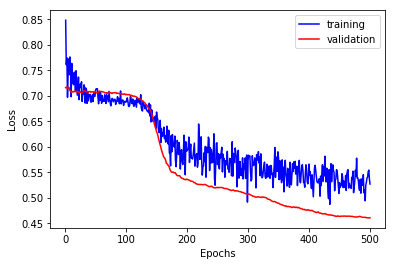

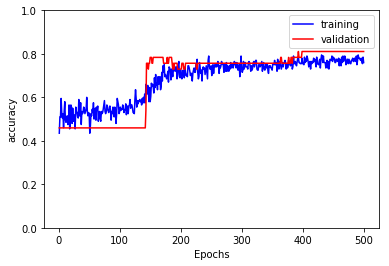

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accu = history.history['acc']
val_accu = history.history['val_acc']

time = range(1,len(loss)+1)

plt.plot(time, loss, 'b-')
plt.plot(time, val_loss, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['training', 'validation'])
plt.show()

plt.plot(time, accu, 'b-')
plt.plot(time, val_accu, 'r-')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(['training', 'validation'])
plt.show()



FIGURE 5. Examination of the model performance comparing the accuracy and loss of validation and training set.
There are indication of overfitting.

After an hour of training using:
- different learning rates = 0.005, 0.0025, 0.0001 = reducing only increased overfitting

- different oprimizers = adam, sgd and rmsprop = Adam worked better; sgd was the worst, while rmsprop needs more tunning on LR and momentum parameter.
- different batch sizes = too small it overfit, and too large make the NN stuck in a fixed Loss/Accuracy value
- different neuron numbers.

For practical reason we leave it trained as it is. 

Problems with overfitting

In [89]:
# Test the model with new unseen data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

60/60 [==============================] - 0s 107us/sample - loss: 0.6656 - acc: 0.6833


In [90]:
test_acc_model1 = test_accuracy*100

In [94]:
test_acc_model1 - default_accuracy*100

12.833333730697625

this is a poor improvement of 12.8%

In [95]:
test_loss

0.6655753890673319

# 2. MODEL 2. small network (2 layers)

In [96]:
model_small = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5, input_shape=(partial_train_data.shape[1],), activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [97]:
model_small.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 5)                 115       
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 6         
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [98]:
model_small.compile(optimizer= 'adam', # 'using ADAM instead of rmsprop
                    #learning_rate = 0.01,Now we are using the deafult learnig rate = 0.01
              loss= 'binary_crossentropy',#'sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [99]:
history_small= model_small.fit(partial_train_data, partial_train_targets,
                    epochs=80, batch_size=10, verbose=0,
                    validation_data = (val_data, val_targets))

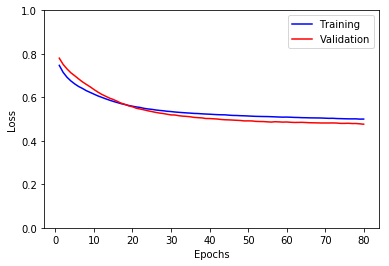

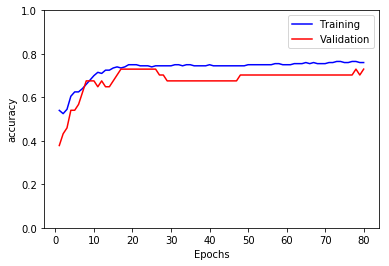

In [100]:
loss = history_small.history['loss']
val_loss = history_small.history['val_loss']
accu = history_small.history['acc']
val_accu = history_small.history['val_acc']

time = range(1,len(loss)+1)

plt.plot(time, loss, 'b-')
plt.plot(time, val_loss, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend(['Training', 'Validation'])
plt.show()

plt.plot(time, accu, 'b-')
plt.plot(time, val_accu, 'r-')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(['Training', 'Validation'])
plt.show()



FIGURE 6. Examination of the model performance comparing the accuracy and loss of validation and training set.
There are indication of overfitting.

We tried using 500, 100 and 80 epochs. The 80 epoch choice revealed the most coherent result.

In [101]:
# Test the model with new unseen data
test_loss, test_accuracy = model_small.evaluate(X_test, y_test)

60/60 [==============================] - 0s 104us/sample - loss: 0.6046 - acc: 0.7000


In [102]:
test_acc_model2 = test_accuracy*100

In [103]:
test_acc_model2 - default_accuracy*100

14.499998807907097

# 3. MODEL 3: small network with regularizer

In [51]:
from tensorflow.keras import regularizers

In [120]:
model_small_reg1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, input_shape=(partial_train_data.shape[1],), activation='sigmoid'),
    tf.keras.layers.Dense(5,kernel_regularizer=regularizers.l2(0.5), activation = 'sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')])


In [121]:
#opt = tf.keras.optimizers.Adam(lr = 0.01) # Here we reduce the Learning rate from 0.01 (default) tp 0.0025

In [122]:
model_small_reg1.compile(optimizer= 'adam', 
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [123]:
history_small_reg1= model_small_reg1.fit(partial_train_data, partial_train_targets,
                    epochs=2500, batch_size = 10, verbose=0,
                    validation_data = (val_data, val_targets))

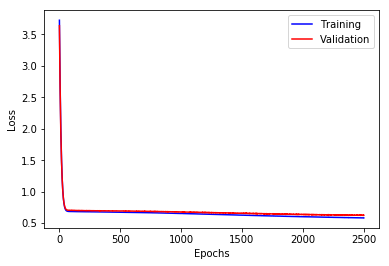

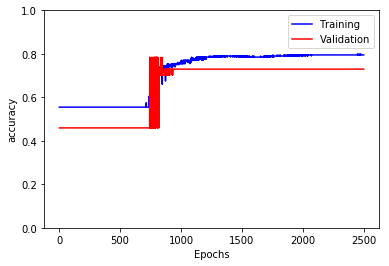

In [124]:
loss = history_small_reg1.history['loss']
val_loss = history_small_reg1.history['val_loss']
accu = history_small_reg1.history['acc']
val_accu = history_small_reg1.history['val_acc']

time = range(1,len(loss)+1)

plt.plot(time, loss, 'b-')
plt.plot(time, val_loss, 'r-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.show()

plt.plot(time, accu, 'b-')
plt.plot(time, val_accu, 'r-')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.ylim(0,1)
plt.legend(['Training', 'Validation'])
plt.show()


FIGURE 7. Examination of the model performance comparing the accuracy and loss of validation and training set.
There are indication of overfitting.

In [125]:
# Test the model with new unseen data
test_loss, test_accuracy = model_small_reg1.evaluate(X_test, y_test)

60/60 [==============================] - 0s 69us/sample - loss: 0.6912 - acc: 0.6500


In [126]:
test_acc_model3 = test_accuracy*100

In [127]:
test_acc_model3 - default_accuracy*100

9.499997615814202

In [1]:
# Improvement of a 9.49%

# V. Model selection

In [144]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [133]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification

# CALCULATING CONFUSION MATRICES AND F1 score

In [135]:
#MODEL1
y_test = y_test.values
results = model.predict(X_test) # Probability
res = model.predict_classes(X_test) # The actual

y_test = y_test
TRUEs = np.arange(len(y_test))
for i in range(len(res)):
   TRUEs[i] = np.array(y_test[i] + res[i])

#MODEL 2
results_small = model_small.predict(X_test) # Probability
res_small = model_small.predict_classes(X_test) # The actual


y_test = y_test
TRUEs_small = np.arange(len(y_test))
for i in range(len(res_small)):
   TRUEs_small[i] = np.array(y_test[i] + res_small[i])

# MODEL 3
results_small_reg1 = model_small_reg1.predict(X_test) # Probability
res_small_reg1 = model_small_reg1.predict_classes(X_test) # The actual

y_test = y_test
TRUEs_small_reg1 = np.arange(len(y_test))
for i in range(len(res_small_reg1)):
   TRUEs_small_reg1[i] = np.array(y_test[i] + res_small_reg1[i])


In [136]:
import collections

print("MODEL1:", collections.Counter(TRUEs)) # Dense model
print("MODEL2:", collections.Counter(TRUEs_small)) # small model
print("MODEL3:", collections.Counter(TRUEs_small_reg1)) # small model with regularization



MODEL1: Counter({0: 27, 1: 19, 2: 14})
MODEL2: Counter({0: 23, 2: 19, 1: 18})
MODEL3: Counter({0: 22, 1: 21, 2: 17})


In [137]:
cm1 = confusion_matrix(y_test, res)
print("Confusion matrix for model 1:\n",cm1)


Confusion matrix for model 1:
 [[27  5]
 [14 14]]


In [138]:
accuracy_2 = (cm1[0][0]+cm1[1][1])/(cm1[0][0]+cm1[1][1]+cm1[0][1]+cm1[1][0])
print("Accuracy MODEL 1 calculated from the training set = %.3f" % (accuracy_2))

print(classification_report(y_test, res, target_names=['0', '1']))

Accuracy MODEL 1 calculated from the training set = 0.683
              precision    recall  f1-score   support

           0       0.66      0.84      0.74        32
           1       0.74      0.50      0.60        28

   micro avg       0.68      0.68      0.68        60
   macro avg       0.70      0.67      0.67        60
weighted avg       0.70      0.68      0.67        60



In [139]:
cm2 = confusion_matrix(y_test, res_small)
print("Confusion matrix for model 2(small):\n",cm2)


Confusion matrix for model 2(small):
 [[23  9]
 [ 9 19]]


In [147]:

accuracy_2 = (cm2[0][0]+cm2[1][1])/(cm2[0][0]+cm2[1][1]+cm2[0][1]+cm2[1][0])
print("Accuracy MODEL 2 calculated from the training set = %.3f" % (accuracy_2))

print(classification_report(y_test, res_small, target_names=['0', '1']))

Accuracy MODEL 2 calculated from the training set = 0.700
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        32
           1       0.68      0.68      0.68        28

   micro avg       0.70      0.70      0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60



In [141]:
cm3 = confusion_matrix(y_test, res_small_reg1)
print("Confusion matrix for model 3 (small + reg1):\n",cm3)

Confusion matrix for model 3 (small + reg1):
 [[22 10]
 [11 17]]


In [142]:

accuracy_2 = (cm3[0][0]+cm3[1][1])/(cm3[0][0]+cm3[1][1]+cm3[0][1]+cm3[1][0])
print("Accuracy MODEL 1 calculated from the training set = %.3f" % (accuracy_2))

print(classification_report(y_test, res_small_reg1, target_names=['0', '1']))

Accuracy MODEL 1 calculated from the training set = 0.650
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        32
           1       0.63      0.61      0.62        28

   micro avg       0.65      0.65      0.65        60
   macro avg       0.65      0.65      0.65        60
weighted avg       0.65      0.65      0.65        60



It seems to be that the  model_small (MODEL 1) exhibit better results based on
confusion matrix metric: both precision and recall and F1.


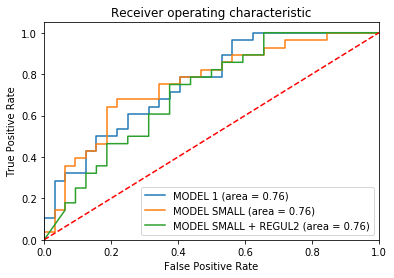

In [146]:
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
logit_roc_auc_small = roc_auc_score(y_test, model.predict(X_test))
logit_roc_auc_small_reg1 = roc_auc_score(y_test, model.predict(X_test))

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test))
fpr_small, tpr_small, thresholds_small = roc_curve(y_test, model_small.predict_proba(X_test))
fpr_small_reg1, tpr_small_reg1, thresholds_small_reg1 = roc_curve(y_test, model_small_reg1.predict_proba(X_test))
plt.figure()
plt.plot(fpr, tpr, label='MODEL 1 (area = %0.2f)' % logit_roc_auc)
plt.plot(fpr_small, tpr_small, label='MODEL SMALL (area = %0.2f)' % logit_roc_auc_small)
plt.plot(fpr_small_reg1, tpr_small_reg1, label='MODEL SMALL + REGUL2 (area = %0.2f)' % logit_roc_auc_small_reg1)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

FIGURE 8. This figure is showing that three models similar performance,
and similar area under the curve, however F1 inidicated that
Model 2(small NN) improved better the prediction.



# VI. RESULTS and DISCUSSION

This project aimed to predict heart disease condition using neural networks as a binary classifier. We build models based on attributes such as blood pressure, cholesterol levels, heart rate, and other features were classified according to varying degrees of coronary artery disease, variable "num", which was binarized (>1 = sick, and <1 = healthy). This project utilized a dataset of 303 patients. Nevertheless, we remove rows with "NaN", using only 297 samples. We could have replaced NaN values with the averages and utilize the full dataset and compare the effect of these six samples on the accuracy. We anyway decided to remove these rows since they represented less than 5% of the dataset, and we considered irrelevant their presence. Chollet 2017 warns us about the fact that a good classifier should be trained with more than 10000 data points. In this sense, if we would have kept those points, we would have never reached the minimum sample size recommended by Chollet 2017 and Haroon 2017.
Despite the presence of NaN, there were no more problems with the dataset. However, we had to standardize the data centring each feature to zero, and we had to encode a few categorical variables as it was recommended by diverse specialists (Chollet 2017, Haroon 2018, Zuur et al. 2010).
We trained three models, and they mainly differ in the combination of a number of neurons, a number of layers, activations types  ('relu', 'elu', 'sigmoid'), and regularization (dropout and l2 regularization). We decided to train each model for 5 hours each; this implied we change parameters each run, registering and keeping those producing better performance on the test set. It seems to be that our first model, which comprised several deep layers performed better, exhibiting ~70% of accuracy on the test set together with an F1-score of 0.74 (the highest of the three models). Also, this model improved the default chance of detecting a sick patient in ~15%. We based the selection mainly on F1-score since our accuracy metric was polluted (biased) by a slight excess of ill patients in comparison to healthy ones.
Additionally, the accuracy results from training data on figures (5, 6, 7) were always higher than the one exhibited in the test set. This situation seems to be a problem of a lack of large dataset to improve the model further. In this sense, it seems to be that this model is prone to overfit (Hoorne 2017).
Using F1 score as a metric, we are sure that if the F1 score is high on model 1, both precision and recall of the classifier indicate good results. That characteristic of the metric allows us to compare the performance of three classifiers (model 1, model 2, model 3) using just this metric. The ROC curve represent the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate better performance. In our case, three of them had a sound performance, with an also similar area under the curve AUC ~72%. These AUCs showed still an improvement from the baseline detected, which in our case was 54%, due to the imbalance of the data).
It is worth mention that every time we initiate the kernel, we obtained different results, it is essential then to save the trained model for further utilization rather than training it every time. Similarly, during the tunning of each model, we used different activation functions. It seems to be that the non-linear sigmoid or 'elu' (notice: "exponential linear unit") performed better for this case, we assumed it is because is a binary classification problem that the usage of sigmoid contributes further to obtain the final result.
The training process was a bit daunting. It is perhaps advisable to use other methods such as logistic regression with smoothers (e.g. Generalized additive models) for these type of problems with small datasets to save time during training (Zuur et al. 2010).

# VII. Conclusion

Neural Network seems to be an excellent candidate to solve complex problems containing multidimensional data. We used a dataset on heart disease conditions to build three binary neural network classifiers to recognize sick and healthy patients according to several variables. Our best classifier neural network contained several layers improving the classification rate from a default of 54% to >70%. It is possible that other neural network can achieve better-obtaining results, however here we concentrate on different extra aspects such a data preprocessing, training and evaluation scores too. All three neural network models were assessed using ROC curves, and besides, the F1 score seems to be better in identifying the best model when the dataset is imbalanced.


# VIII. References

1. Chollet, F. 2017. Deep Learning with Python. Manning Publications Co. USA. 384 pages
2. Hoorne, D. 2017. Python Machine Learning Case Studies. Apress.editors. Karachi, Pakistan, 205 pages.
3. Zuur, A., Ieno, E., and Ch. Elphick. 2010. A protocol for data exploration to avoid common statistical problems. Methods in Ecology and Evolution 1, 3-14